In [1]:
import io

import numpy as np
import matplotlib.pyplot as plt

from ase.io import read, write

from molent.molent import entropy, binary_similarity, cosine_similarity

In [2]:
# some small molecules and their information entropy
# see D.Sh. Sabirov / Computational and Theoretical Chemistry 1123 (2018) 169–179
molecule_entropies = {
    'C': 0.722, # CH4
    'N': 0.811, # NH3
    'O': 0.918, # H2O
    'C#C': 1.000, # C2H2    
    'C#N': 1.585, # HCN
    'C=O': 1.5, # CH2O    
    'CC': 0.811, # C2H6
    'CO': 1.792, # CH3OH        
    'CCO': 2.419, # CH3CH2OH
    'COC': 1.224, # CH3OCH3
    'CCC': 1.685, # CH3CH2CH3
    'CC(C)(C)C': 1.086, # neopentane
    'CCCCC': 2.351 # pentane
}

# Read Data from QM9 Dataset

The dataset can be downloaded from https://doi.org/10.6084/m9.figshare.c.978904.v5

In [5]:
qm9_dir = '../../../QM9/dsgdb9nsd.xyz/' # adjust to your QM9 directory

In [6]:
from molent.tools import cleanup_qm9_xyz

all_atoms = []
all_smiles = []

for i in [1, 2, 3, 4, 5, 6, 7, 8, 13, 14, 15, 54, 133]:
    ind, gdb_smi, relax_smi = cleanup_qm9_xyz(qm9_dir+'dsgdb9nsd_%06i.xyz' % i)
    
    all_atoms.append(read(io.StringIO(ind), format='xyz'))
    all_smiles.append(relax_smi)

# Fragment Smiles &rarr; Entropies

In [7]:
from molent.molent import fragment_smiles

coll_SmilesHs = []

fragsmiles = fragment_smiles(all_smiles, N_rad = 0, useHs = True)
smiles_entropies = [entropy(binary_similarity(fs)) for fs in fragsmiles]
coll_SmilesHs.append(smiles_entropies)

fragsmiles = fragment_smiles(all_smiles, N_rad = 1, useHs = True)
smiles_entropies = [entropy(binary_similarity(fs)) for fs in fragsmiles]
coll_SmilesHs.append(smiles_entropies)

fragsmiles = fragment_smiles(all_smiles, N_rad = 2, useHs = True)
smiles_entropies = [entropy(binary_similarity(fs)) for fs in fragsmiles]
coll_SmilesHs.append(smiles_entropies)

N_rad = 3
fragsmiles = fragment_smiles(all_smiles, N_rad = 3, useHs = True)
smiles_entropies = [entropy(binary_similarity(fs)) for fs in fragsmiles]
coll_SmilesHs.append(smiles_entropies)

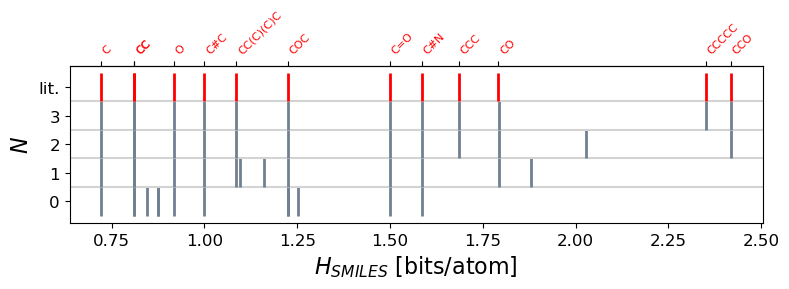

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8,3))

for i in range(len(coll_SmilesHs)):
    ax.vlines(coll_SmilesHs[i], i-1, i, color='slategrey', lw=2)
    ax.axhline(y=i, color='lightgrey')

ax.vlines(list(molecule_entropies.values()), len(coll_SmilesHs)-1, len(coll_SmilesHs), color='red', lw=2)

ax_xr = ax.secondary_xaxis('top')
ax_xr.set_ticks(list(molecule_entropies.values()), labels=list(molecule_entropies.keys()), 
                color='red', fontsize=8, rotation=45, ha='left')

lab = list(range(0,len(coll_SmilesHs)+1))
lab[-1] = 'lit.'
ax.set_yticks(np.arange(0,len(coll_SmilesHs)+1)-0.5, labels=lab)

ax.set_xlabel(r'$H_{SMILES}$ [bits/atom]', fontsize=16)
ax.set_ylabel(r'$N$', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()
#plt.savefig('ent_smiles.pdf')

# SOAP &rarr; Entropies

In [9]:
from dscribe.descriptors import SOAP

# SOAP parameters
species = ["C", "H", "O", "N", "F"]
r_cut = 6.
n_max = 10
l_max = 6

# setting up the SOAP descriptor
soap = SOAP(
    species=species,
    periodic=False,
    r_cut=r_cut,
    n_max=n_max,
    l_max=l_max,
)

soap_mol = soap.create(all_atoms)

In [10]:
coll_SoapHs = []

zeta = 1
soap_entropies = []
for i in range(len(all_atoms)):
    at_nums = all_atoms[i].get_atomic_numbers()
    S = cosine_similarity(soap_mol[i], at_nums=at_nums)**zeta
    soap_entropies.append(entropy(S))
coll_SoapHs.append(soap_entropies)

zeta = 4
soap_entropies = []
for i in range(len(all_atoms)):
    at_nums = all_atoms[i].get_atomic_numbers()
    S = cosine_similarity(soap_mol[i], at_nums=at_nums)**zeta
    soap_entropies.append(entropy(S))
coll_SoapHs.append(soap_entropies)

zeta = 16
soap_entropies = []
for i in range(len(all_atoms)):
    at_nums = all_atoms[i].get_atomic_numbers()
    S = cosine_similarity(soap_mol[i], at_nums=at_nums)**zeta
    soap_entropies.append(entropy(S))
coll_SoapHs.append(soap_entropies)

# Comparison

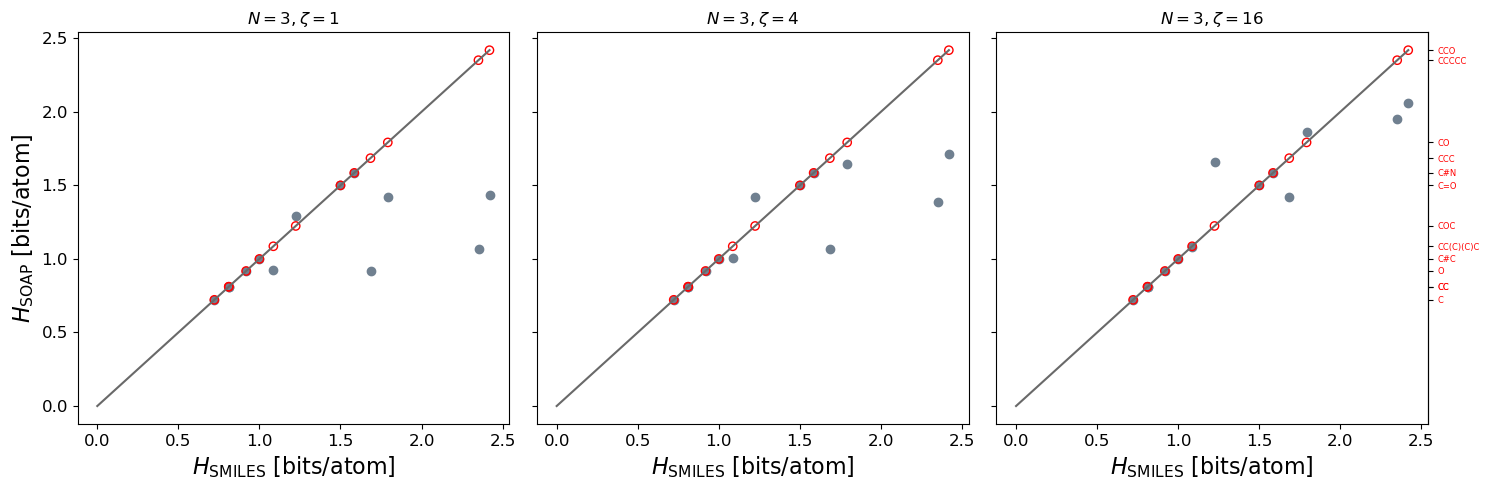

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5), sharey=True)
ax1.scatter(smiles_entropies, coll_SoapHs[0], color='slategrey')
ax1.scatter(list(molecule_entropies.values()), list(molecule_entropies.values()), 
           color='red', marker='o', facecolor='none')
ax1.plot([0, np.max(smiles_entropies)], [0, np.max(smiles_entropies)], color='dimgrey')


ax2.scatter(smiles_entropies, coll_SoapHs[1], color='slategrey')
ax2.scatter(list(molecule_entropies.values()), list(molecule_entropies.values()), 
           color='red', marker='o', facecolor='none')
ax2.plot([0, np.max(smiles_entropies)], [0, np.max(smiles_entropies)], color='dimgrey')


ax3.scatter(smiles_entropies, coll_SoapHs[2], color='slategrey')
ax3.scatter(list(molecule_entropies.values()), list(molecule_entropies.values()), 
           color='red', marker='o', facecolor='none')
ax3.plot([0, np.max(smiles_entropies)], [0, np.max(smiles_entropies)], color='dimgrey')


ax_yr = ax3.secondary_yaxis('right')
ax_yr.set_ticks(list(molecule_entropies.values()), labels=list(molecule_entropies.keys()), 
                color='red', fontsize=6)

ax1.set_title(r'$N=%i, \zeta=%i$' % (N_rad,1), fontsize=12)
ax2.set_title(r'$N=%i, \zeta=%i$' % (N_rad,4), fontsize=12)
ax3.set_title(r'$N=%i, \zeta=%i$' % (N_rad,16), fontsize=12)

#ax.set_aspect('equal')
ax1.set_ylabel(r'$H_{\rm SOAP}$ [bits/atom]', fontsize=16)
ax1.set_xlabel(r'$H_{\rm SMILES}$ [bits/atom]', fontsize=16)
ax2.set_xlabel(r'$H_{\rm SMILES}$ [bits/atom]', fontsize=16)
ax3.set_xlabel(r'$H_{\rm SMILES}$ [bits/atom]', fontsize=16)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax3.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()
#plt.savefig('ent_soap_smiles_zetas.pdf')